# Greenhouse Model

## Import dependencies and data

In [256]:
# import dependencies

import time
import os
import pickle
import json
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

In [257]:
from data_funcs import k_fold_data_validation

In [258]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
results_path = home_path + '\\nn_models\\results\\'

# get merged data
data = pd.read_csv(
    data_path + 'data_processed.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

In [259]:
# define data specs
k_frac = 0.05
m = 5
t_steps = 1
n_steps = 6

# Define cols to use
cols = [
    ('temperatures', 'TA01_GT10X_GM10X'),
    #('temperatures', 'TA01_GT401_GM401_scaled'),
    #('temperatures', 'DC_GT301_damped_scaled'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('sun', 'gsi'),
    ('power', 'phase'),
    ('time', 'minofday'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output')
]

## Get data for all folds

In [260]:
version = 0

In [264]:
models = [
    ('ffnn', 'FFNN'),
    ('rnn', 'RNN'),
    ('gbdt', 'gbdt'),
    ('arima', 'arima')
]

mse_results = {
    'ffnn':[],
    'rnn':[],
    'gbdt':[],
    'arima':[]
}

time_results = {
    'ffnn':[],
    'rnn':[],
    'gbdt':[],
    'arima':[]
}

test_preds = {
    'ffnn':[],
    'rnn':[],
    'gbdt':[],
    'arima':[]
}

for k_idx in range(20):
    # get test data
    _, test_tup, _, col_params = k_fold_data_validation(
        data=data.copy(), 
        k_idx=k_idx, 
        k_frac=k_frac, 
        m=m, 
        cols=cols, 
        t_steps=t_steps, 
        n_steps=n_steps,
        setpoint=True,
        shuffle=False
    )
    
    # extract test targets
    (sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, _) = test_tup
    
    # get MSE for all models
    for model in models:
        folder_name, file_name = model
        
        model_name = '{}_v{}_k{}'.format(file_name, version, k_idx)
        load_path = results_path + folder_name + '\\' + model_name + '.pickle'

        with open(load_path, 'rb') as fo:
            results = pickle.load(fo)
            
        preds = results['test_preds']
        
        if len(preds) > len(targets_test):
            preds = preds[1:]
        
        mse = np.square(targets_test - preds).mean()
        mse_results[folder_name].append(mse)
        
        time_results[folder_name].append(results['train_time'])
        
        test_preds[folder_name].append(preds)
    
    

# PLOTS

In [142]:
plot_path = home_path + '\\nn_models\\plots\\'

In [143]:
# set plot defaults
plt.rcdefaults()

font = {
    'family' : 'arial',
    'weight' : 'normal',
    'size'   : 14
}

tit_font = {
    'family' : 'arial',
    'weight' : 'bold',
    'size'   : 16
}

suptit_font = {
    'family' : 'arial',
    'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)

## K-fold CV MSE

In [266]:
rnn_mse = mse_results['rnn']
ffnn_mse = mse_results['ffnn']
arima_mse = mse_results['arima']
gbdt_mse = mse_results['gbdt']

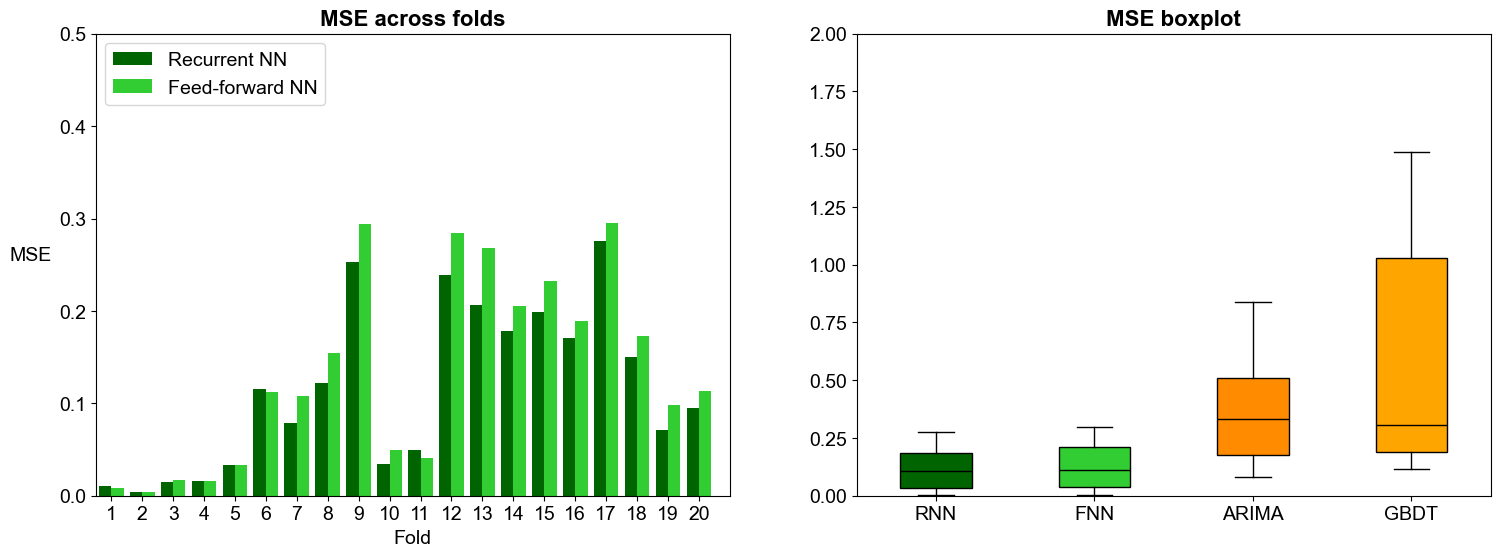

In [267]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax1.bar(np.arange(1, 21)-0.2, rnn_mse, width=0.4, bottom=0, color='darkgreen', label='Recurrent NN')
ax1.bar(np.arange(1, 21)+0.2, ffnn_mse, width=0.4, bottom=0, color='limegreen', label='Feed-forward NN')

ax1.set_xlim(0.5, 21)
ax1.set_ylim(0, 0.5)
ax1.set_xticks(range(1, 21))
ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE', rotation=0, labelpad=20)
ax1.legend(loc='upper left')
ax1.set_title('MSE across folds', **tit_font)

#ax2.set_facecolor('')
#ax2.grid()
# bplot = ax2.boxplot([gbdt_large_mse[:-2], gbdt_mse[:-2], arima_mse[:-2], lstm_mse[:-2]], patch_artist=True, showfliers=False)
bplot = ax2.boxplot([rnn_mse, ffnn_mse, arima_mse, gbdt_mse], patch_artist=True, showfliers=False)
ax2.set_ylim(0, 2)
ax2.set_xticklabels(['RNN', 'FNN', 'ARIMA', 'GBDT'])
ax2.set_title('MSE boxplot', **tit_font)

# fill with colors
# colors = ['green', 'lightgreen', 'navy', 'orange']
colors = ['darkgreen', 'limegreen', 'darkorange', 'orange']
for patch, color, median in zip(bplot['boxes'], colors, bplot['medians']):
    patch.set_facecolor(color)
    median.set_color('black')

#plt.savefig(plot_path + 'k_fold_model_comp.png', dpi=200, bbox_inches='tight')
plt.show()

In [272]:
print(
    np.array(rnn_mse).mean(),
    np.array(ffnn_mse).mean(),
    np.array(arima_mse).mean(),
    np.array(gbdt_mse).mean()
)

0.1158810371363348 0.13487164841263388 0.5134731450176877 1.1856639935603703


## K-fold CV Time

In [268]:
rnn_time = [np.sum(times) for times in time_results['rnn']]
ffnn_time = [np.sum(times) for times in time_results['ffnn']]
arima_time = time_results['arima']
gbdt_time = time_results['gbdt']

In [273]:
print(
    np.array(rnn_time).mean(),
    np.array(ffnn_time).mean(),
    np.array(arima_time).mean(),
    np.array(gbdt_time).mean()
)

32.006720745563506 6.49981404542923 40.57423428297043 319.31872515678407


In [ ]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# fig.set_size_inches(18, 6)

# ax1.barh(np.arange(1, 21), rnn_time, color='darkgreen')
# ax2.barh(np.arange(1, 21), ffnn_time, color='limegreen')
# ax3.barh(np.arange(1, 21), arima_time, color='darkorange')
# ax4.barh(np.arange(1, 21), gbdt_time, color='orange')

# ax1.set_xlim(0, 350)
# ax2.set_xlim(0, 350)
# ax3.set_xlim(0, 350)
# ax4.set_xlim(0, 350)

## Examp output

In [129]:
temp_mean, temp_std, _, _ = col_params[('temperatures', 'TA01_GT10X_GM10X')].values()

targets = targets_test * temp_std + temp_mean
rnn_preds = np.stack(test_preds['rnn'][-1]) * temp_std + temp_mean
fnn_preds = np.stack(test_preds['ffnn'][-1]) * temp_std + temp_mean
# arima_preds = test_preds['arima']
# gbdt_preds = test_preds['gbdt']

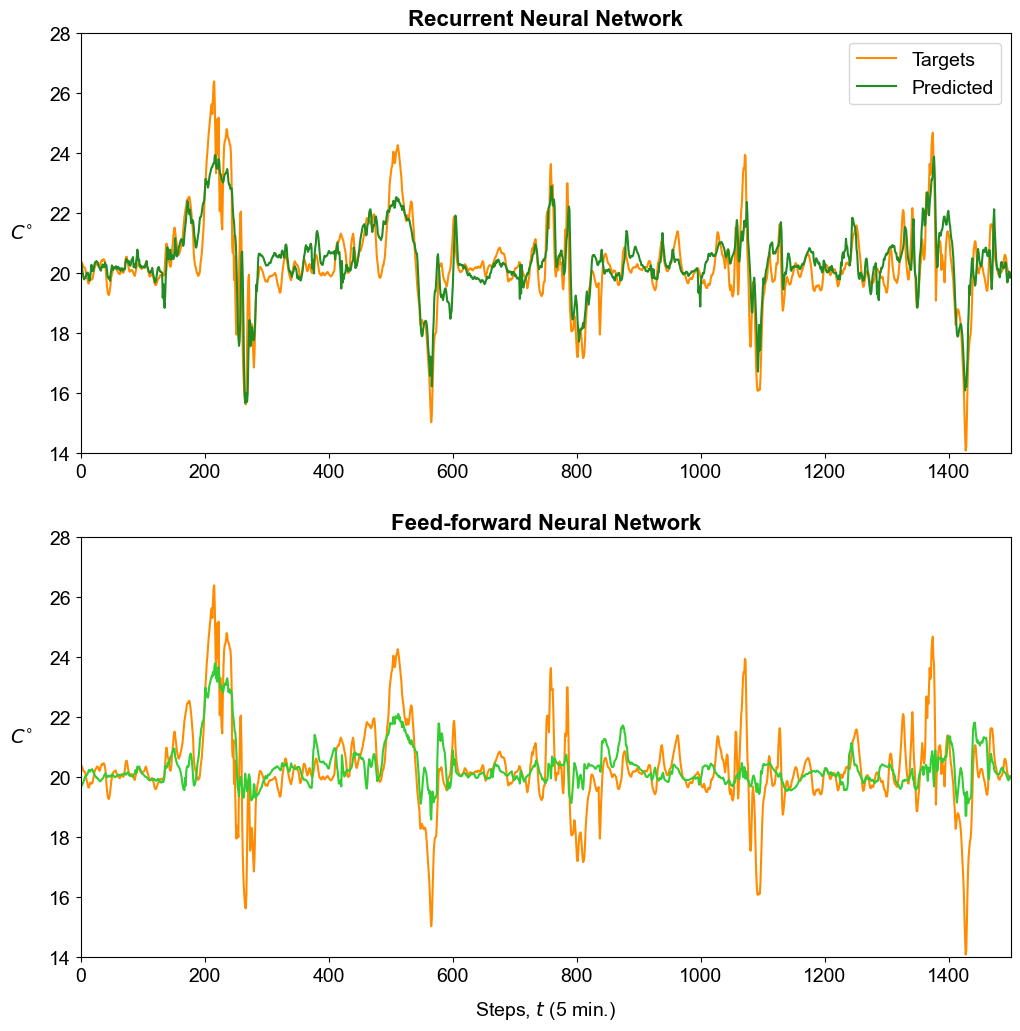

In [255]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(12, 12)

ax1.plot(targets[-1500:], color='darkorange', alpha=1.0, label='Targets')
ax2.plot(targets[-1500:], color='darkorange', alpha=1.0, label='Targets')
ax1.plot(rnn_preds[-1500:], color='forestgreen', label='Predicted')
ax2.plot(fnn_preds[-1500:], color='limegreen', label='Predicted')

ax1.set_xlim(0, 1500)
ax2.set_xlim(0, 1500)
ax1.set_ylim(14, 28)
ax2.set_ylim(14, 28)

ax1.set_ylabel('$C^{\circ}$', rotation=0, labelpad=20)
ax2.set_ylabel('$C^{\circ}$', rotation=0, labelpad=20)
ax2.set_xlabel('Steps, $t$ (5 min.)', labelpad=10)

ax1.set_title('Recurrent Neural Network', **tit_font)
ax2.set_title('Feed-forward Neural Network', **tit_font)

ax1.legend(loc='upper right')
ax1.legend(loc='upper right')

plt.savefig(plot_path + 'rnn_fnn_comp.png', dpi=200)
plt.show()

## Effects of using GSI

## Approximation of $\phi$

In [144]:
def grid_estimation(seq, k, col_params, model):
    
    ta01_mean = col_params[('state', 'TA01_output')]['mean']
    ta01_std = col_params[('state', 'TA01_output')]['std']
    ta02_mean = col_params[('state', 'TA02_output')]['mean']
    ta02_std = col_params[('state', 'TA02_output')]['std']
    
    ta01 = (np.linspace(0, 100, k) - ta01_mean) / ta01_std
    ta02 = (np.linspace(0, 100, k) - ta02_mean) / ta02_std
    
    seqs = []
    
    for i in range(k):
        for j in range(k):
            new_seq = seq.copy()
            new_seq[-1, -2] = ta01[j]
            new_seq[-1, -1] = ta02[i]
            
            seqs.append(new_seq)
    
    return seqs

In [155]:
from networks import feedForwardNeuralNetwork, recurrentNeuralNetwork

k1 = 7
k2 = 1
m = 32
seed = 1

model = recurrentNeuralNetwork(
    k1=k1,
    k2=k2,
    m=m,
    seed=seed
)

model.weights = results['weights']

In [212]:
k = 100

In [213]:
seqs = grid_estimation(sequences_test[100], k, col_params, model)

In [214]:
preds, _ = model.predict(np.stack(seqs), np.ones((k*k, 1)) * temps_t_test[0][0], train=False)
preds = preds.reshape((100, 100)) * temp_std + temp_mean

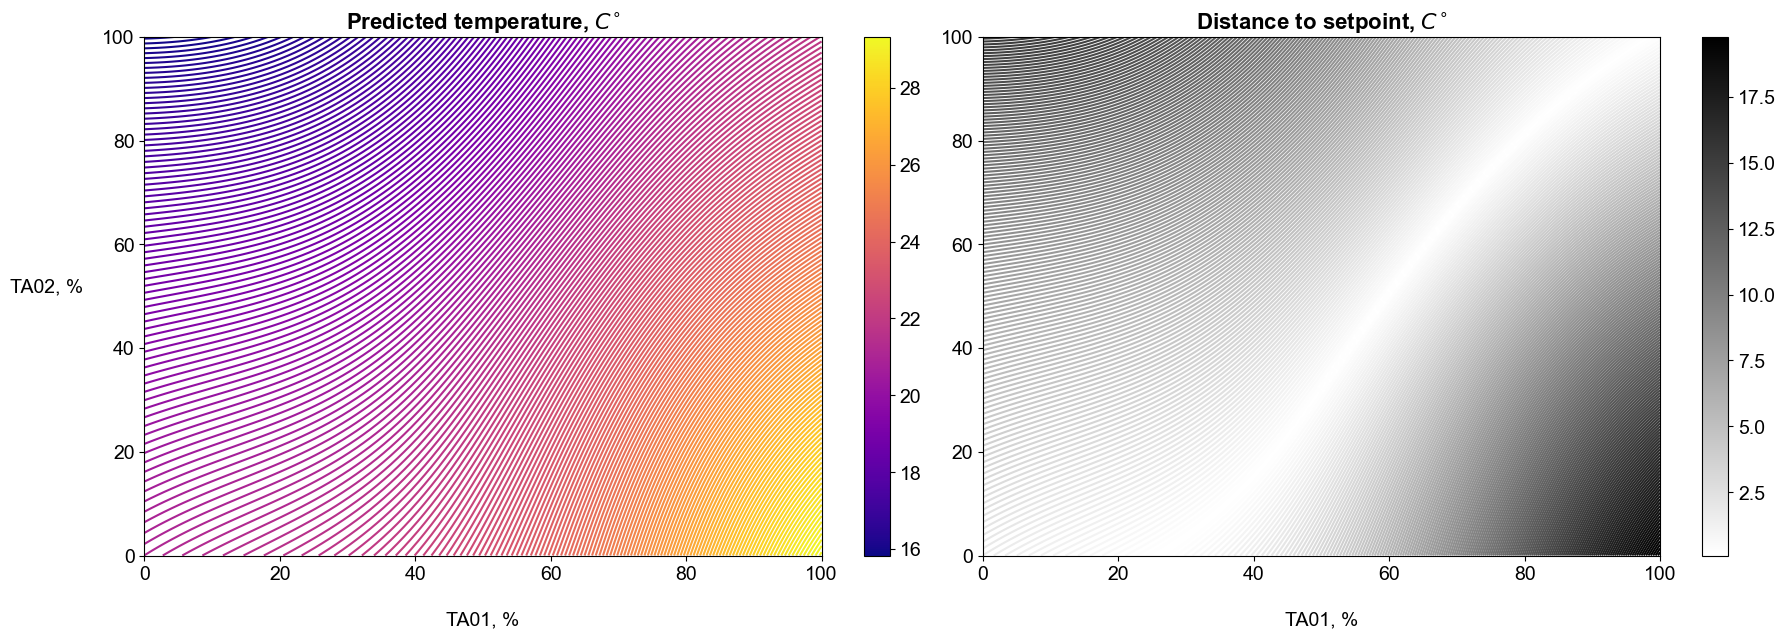

In [243]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

x, y = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, 100, 100))

#heatmap1 = ax1.imshow(np.flip(preds, 0), cmap='plasma')#, extent=[ta01_min, ta01_max, ta02_min, ta02_max])
contour = ax1.contour(x, y, np.flip(preds, 0), levels=200, cmap='plasma')
fig.colorbar(heatmap1, ax=ax1)
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)
ax1.set_ylabel('TA02, %', rotation=0, labelpad=40)
ax1.set_xlabel('TA01, %', labelpad=20)
ax1.set_title('Predicted temperature, $C^{\circ}$', **tit_font)

#heatmap2 = ax2.imshow(np.abs(20 - np.flip(preds, 0)), cmap='binary')
contour = ax2.contour(x, y, np.abs(20 - np.flip(preds, 0)), levels=200, cmap='binary')
fig.colorbar(heatmap2, ax=ax2)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)
#ax2.set_ylabel('TA02, %', rotation=0, labelpad=40)
ax2.set_xlabel('TA01, %', labelpad=20)
ax2.set_title('Distance to setpoint, $C^{\circ}$', **tit_font)

fig.tight_layout(pad=-0.5)
plt.savefig(plot_path + 'temp_grid.png', dpi=200, bbox_inches='tight')
plt.show()

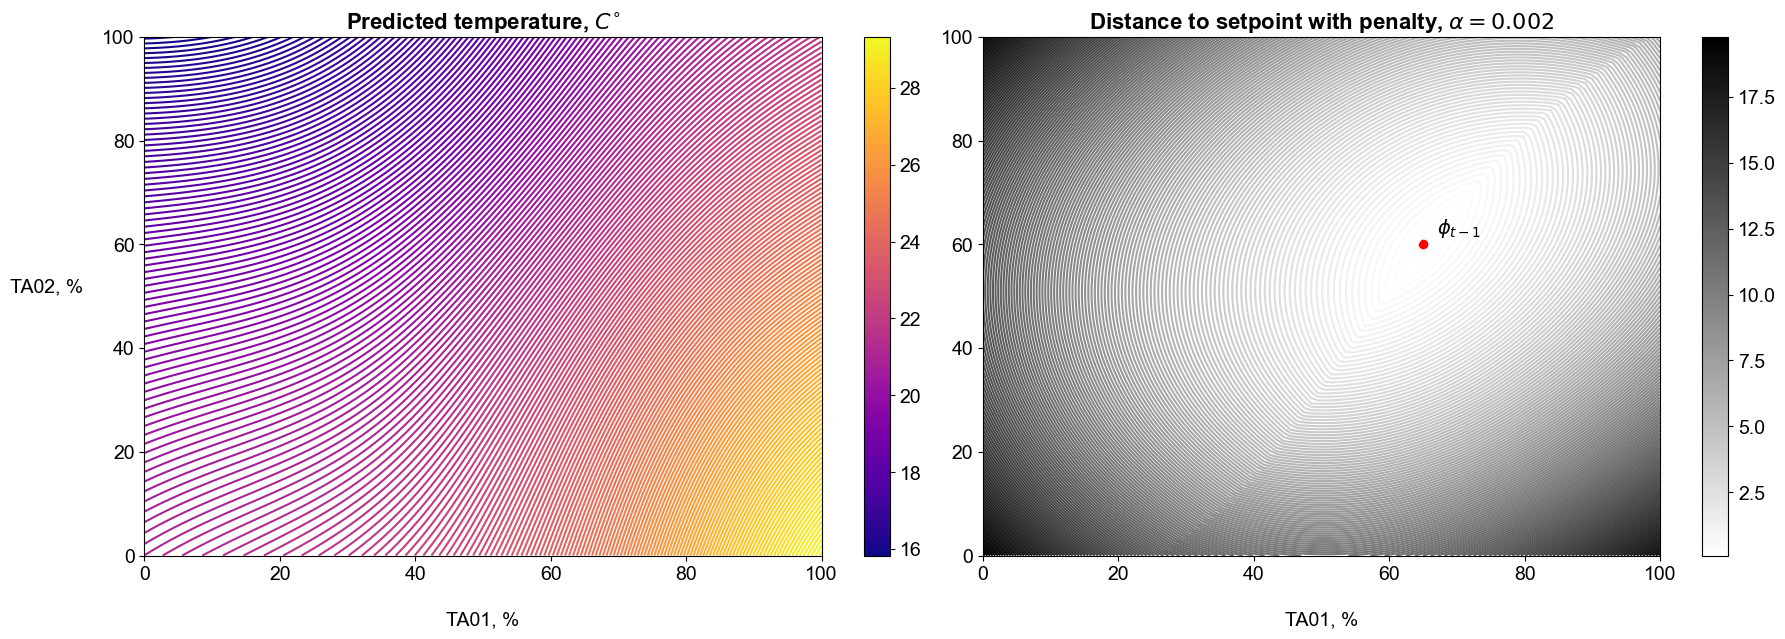

In [244]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

x, y = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, 100, 100))

#heatmap1 = ax1.imshow(np.flip(preds, 0), cmap='plasma')#, extent=[ta01_min, ta01_max, ta02_min, ta02_max])
contour = ax1.contour(x, y, np.flip(preds, 0), levels=200, cmap='plasma')
fig.colorbar(heatmap1, ax=ax1)
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)
ax1.set_ylabel('TA02, %', rotation=0, labelpad=40)
ax1.set_xlabel('TA01, %', labelpad=20)
ax1.set_title('Predicted temperature, $C^{\circ}$', **tit_font)

penalty = 0.001
ta01_init = 65
ta02_init = 60
distances = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        distances[i, j] = abs(j - ta01_init)**2 + abs(i - ta02_init)**2
        
penalty = 0.002
values = np.abs(20 - np.flip(preds, 0)) + penalty * distances

# heatmap2 = ax2.imshow(values, cmap='binary')
contour = ax2.contour(x, y, values, levels=200, cmap='binary')
fig.colorbar(heatmap2, ax=ax2)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)
#ax2.set_ylabel('TA02, %', rotation=0, labelpad=40)
ax2.set_xlabel('TA01, %', labelpad=20)
ax2.set_title('Distance to setpoint with penalty, $\\alpha = 0.002$', **tit_font)

ax2.scatter(ta01_init, ta02_init, color='red')
ax2.annotate('$\phi_{t-1}$', (ta01_init+2, ta02_init+2))

fig.tight_layout(pad=-0.5)
plt.savefig(plot_path + 'temp_grid_penalty.png', dpi=200, bbox_inches='tight')
plt.show()